### Data Estimation and Inference (GPs) Lab session
---

By Paul Duckworth

CDT Data Estimation and Inference Lab session: http://www.robots.ox.ac.uk/~mosb/aims_cdt/

Some nice content on Kernels here: http://www.cs.toronto.edu/~duvenaud/cookbook/

and a nice tutorial here: http://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf


In [1]:
from __future__ import division
import math
import numpy as np
import scipy as sp
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser  
import itertools
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9) # Width and height

In [2]:
# # We first load the weather sensor data from the Port of Southampton:
url="http://www.robots.ox.ac.uk/~mosb/teaching/AIMS_CDT/sotonmet.txt"
data=pd.read_csv(url)

data.drop(['Update Date and Time (ISO)', 'Update Duration (ms)'], axis=1, inplace=True)
data.rename(columns = {'Tide height (m)':'y', 
                       'Reading Date and Time (ISO)':'t'}, inplace = True)

data['parsed t'] = [dateutil.parser.parse(t) for t in data['t']]
data['timeline'] = data.index

train_set = data[~np.isnan(data['y'])]
test_set = data[np.isnan(data['y'])]

print "check split:", train_set.shape, test_set.shape, test_set.shape[0] + train_set.shape[0], data.shape
data.head()


check split: (917, 19) (341, 19) 1258 (1258, 19)


,t,Air pressure (mb),Air temperature (C),y,Wind direction (deg),Wind gust speed (kn),Wind speed (kn),True air temperature (C),True tide height (m),Independent tide height prediction (m),Independent tide height deviation (m),Dependent tide height prediction (m),Dependent tide height deviation (m),Independent air temperature prediction (C),Independent air temperature deviation (C),Dependent air temperature prediction (C),Dependent air temperature deviation (C),parsed t,timeline
0,2007-05-26T12:05:00,NaN,NaN,NaN,NaN,NaN,NaN,16.92,2.30,2.4007,0.039110,2.3715,0.036670,17.2348,0.23222,17.2339,0.23187,2007-05-26 12:05:00,0
1,2007-05-26T12:10:00,1006.0,16.7,2.3,22.0,12.0,12.4,16.42,2.24,2.4016,0.058707,2.3365,0.045564,17.1932,0.29931,17.1848,0.29732,2007-05-26 12:10:00,1
2,2007-05-26T12:15:00,1006.0,16.0,2.2,13.0,18.1,13.2,16.00,2.19,2.2945,0.037006,2.2836,0.029853,16.8005,0.25186,16.8130,0.24920,2007-05-26 12:15:00,2
3,2007-05-26T12:20:00,1006.0,15.9,2.1,16.0,14.2,13.0,15.92,2.14,2.1455,0.021627,2.1553,0.019945,16.0734,0.17207,16.0621,0.17101,2007-05-26 12:20:00,3
4,2007-05-26T12:25:00,1005.0,16.1,2.1,12.0,14.4,12.0,16.08,2.09,2.0900,0.028609,2.1115,0.023468,15.8401,0.21507,15.8126,0.21158,2007-05-26 12:25:00,4


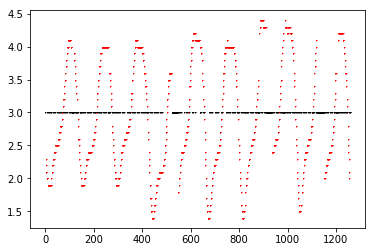

In [3]:
## Plot the Tide height (m) against reading time/day
plt.plot(train_set.timeline, train_set.y,'r+', markersize=1)

## Test points are here:
plt.plot(test_set.timeline, np.ones(len(test_set.timeline))*3,'k+', markersize=1)

# plt.axis([0, 100, 1, 5])
# plt.xticks(train_set.timeline.iloc[::400], train_set.t[::400], rotation=0)
plt.show()

In [4]:
#reshape train and test X data:
X = np.array(train_set.timeline.values)
Xtest = np.array(test_set.timeline.values)

#normalise to zero mean and unit std
y_ = np.array(train_set.y.values)
y = (y_ - y_.mean())/np.std(y_)

ytrue_ = np.array(test_set['True tide height (m)'].values)
ytrue = (ytrue_ - y_.mean())/np.std(y_)

Kernels
---

Exponentiated quadratic kernel (RBF): 

$$ k(x, x') = \sigma^{2}_{f} exp (-\frac{1}{2l^2}(x - x')^2), $$ 
where $\sigma_f$ is the variance and $l$ the length hyperparameter.

In [60]:
## Exponentiated Quadratic kernel (RBF):
def EQ_kernel_vec(a, b, l=1.0, sig=1.0):
    """GP squared exponential kernel - vectorised"""
    a = a.reshape(a.shape[0],1)
    b = b.reshape(b.shape[0],1)
    
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    K = (sig**2)*np.exp((-sqdist/float(2*l**2)))       
    return K

# def Periodic_kernel(a, b, lengthscale = 1., sigma=1., p=1.):
#     """Periodic Covariance function"""
#     d1 = np.subtract.outer(a, a)
#     d2 = np.subtract.outer(a, b)
#     d3 = np.subtract.outer(b, b)
#     K = (sigma**2) * np.exp(-2* (np.sin(np.pi * d1 / p)**2 / lengthscale**2))
#     Ks = (sigma**2) * np.exp(-2* (np.sin(np.pi * d2 / p)**2 / lengthscale**2))
#     Kss = (sigma**2) * np.exp(-2* (np.sin(np.pi * d3 / p)**2 / lengthscale**2))
#     return K, Ks, Kss

In [6]:
# Compare vector to for loops kernel
# %time K = EQ_kernel(X, X)
# %time K = EQ_kernel_vec(X, X)
# %time K = EQ_kernel_sci(X) # square matrices only 

# %timeit K = RQ_kernel(Xtest, Xtest)
# %timeit K = RQ_kernel_vec(Xtest, Xtest)

In [59]:
N = len(X)
K = EQ_kernel_vec(X, X) + 1e-1**2*np.eye(N)   # added some gaussian Noise
Kstar= EQ_kernel_vec(X, Xtest) 
Kstarstar = EQ_kernel_vec(Xtest, Xtest) 

print K.shape, Kstar.shape, Kstarstar.shape
# plt.imshow(Kstarstar, interpolation='nearest')#, cmap=plt.cm.Blues)
# plt.colorbar()

# K, Kstar, Kstarstar = Periodic_kernel(X, Xtest, 2., 0.01, 10)
# print K.shape, Kstar.shape, Kstarstar.shape



(917, 917) (917, 341) (341, 341)


Prior
---

Define a range of test points along x-axis, and use the kernel and the cholesky decomposition (for inverting K), in order to draw samples from the prior using:
$$f_i \sim \mathcal{N}(0_N, K_{N \times N}),$$
where 
$$K_{N \times N} = k(X, X). $$

This defines a positive definite matrix $K$ which can be decomposed: $$ K = LL^T,$$ leading to: $$f_i \sim \mathcal{N}(0_N, I_{N\times N})\times L ,$$
where $L$ is a lower tri-matrix from the cholesky decomposition. 


In [8]:
# ### draw samples from the prior at test points
# n = len(Xtest)  # number of test points 

# L = np.linalg.cholesky(Kstarstar + 1e-6*np.eye(n))
# # np.linalg.eigvals(Kstarstar + s*np.eye(n)) # add a small delta so matrix is positive definite. 

# rand = np.random.normal(size=(n,3))         # random draws of length n
# f_prior = np.dot(L, rand)
# plt.axis([0, 200, -4, 4])                   # date axis
# plt.plot(Xtest, f_prior)

# plt.title("Three samples from the GP prior"), plt.xlabel('x'), plt.ylabel("k(x,x')")
# plt.show()


Posterior 
---

Given some data $\mathcal{D} = \{ (\boldsymbol{x}_i, f_i), i = 1:N\}$ where $ f_i = f(\boldsymbol{x}_i)$. 

Then the noise-free joint distribution of the training outputs $\boldsymbol{f}$ and the test outputs $\boldsymbol{f_{*}}$can be specified as:

$$
\begin{pmatrix} 
\boldsymbol{f}   \\ 
\boldsymbol{f}_{*}  \\ 
\end{pmatrix} \sim \mathcal{N} 
\begin{pmatrix} 
    \begin{pmatrix} 
        \boldsymbol{\mu}   \\ 
        \boldsymbol{\mu}_{*}  \\ 
    \end{pmatrix},
    \begin{pmatrix} 
        K       &  K_{*}  \\ 
        K_{*}^T &  K_{**} \\ 
    \end{pmatrix}
\end{pmatrix}
$$

Then the posterior is defined by conditioning on the observed data $\mathcal{D}$: 

$$
p(\boldsymbol{f}_{*} \mid X_{*}, X, \boldsymbol{f})  = 
    \mathcal{N}(\boldsymbol{f}_{*} \mid \boldsymbol{\mu}_{*}, \Sigma_{*}), 
$$
    
where:
$$
\begin{align}    
\boldsymbol{\mu}_{*} & =  \boldsymbol{\mu}(X_{*}) + K_{*}^T K^{-1} (\boldsymbol{f} - \boldsymbol{\mu}(X))\\
\Sigma_{*}           & = K_{**} - K_{*}^T K^{-1}K_{*}
\end{align}
$$


With added noise on the observed training points, this joint distribution can be altered to: 

$$
\begin{pmatrix} 
\boldsymbol{y}   \\ 
\boldsymbol{f}_{*}  \\ 
\end{pmatrix} \sim \mathcal{N} 
\begin{pmatrix} 
    \begin{pmatrix} 
        \boldsymbol{\mu}   \\ 
        \boldsymbol{\mu}_{*}  \\ 
    \end{pmatrix},
    \begin{pmatrix} 
        K + \sigma_n^2 I      &  K_{*}  \\ 
        K_{*}^T &  K_{**}\\
    \end{pmatrix}
\end{pmatrix}, 
$$
where $y = f(\boldsymbol{x}) + \epsilon$ where there is added iid Gaussian noise $\epsilon$ with variance $\sigma_n^2 I$. 

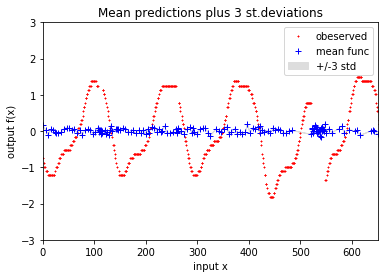

In [58]:
# compute the mean at each of our (x-axis) test points.
N = len(X) # number of train points
mu = y.mean()

# decompose K (instead of inverting it)
jitter = np.eye(N)*1e-6**2
L = np.linalg.cholesky(K+jitter)

# solve for m where: L*m = y
m = np.linalg.solve(L, y-mu)

# solve for alpha where: L.T*alpha = m
alpha = np.linalg.solve(L.T, m)
mu_star = np.dot(Kstar.T, alpha) + mu

Lk = np.linalg.solve(L, Kstar)
mu_nando = np.dot(Lk.T, m) + mu

plt.clf()
plt.plot(X, y, 'r+', ms=2)             # observed data points  (red)
plt.plot(Xtest, mu_star, 'b+', lw=2)   # mean function \mu 
# plt.plot(Xtest, ytrue, 'y+')           # actual true process creating the data (blue)
plt.axis([0, 650, -3, 3])

# compute the variance at our test points - each point along the x-axis.
# solve for v where: Lv = Kstar
v = np.linalg.solve(L, Kstar)

# v_star = np.diag(np.sqrt(var))
v_star = np.sqrt(np.diag(Kstarstar) - np.sum(v**2, axis=0))

plt.gca().fill_between(Xtest.flat, mu_star-3*v_star, mu_star+3*v_star, color="#dddddd")

plt.xlabel('input x'),plt.ylabel('output f(x)')
plt.legend(['obeserved', 'mean func', '+/-3 std', 'true points'])
plt.title('Mean predictions plus 3 st.deviations')

plt.show()

Let's explain what we just did: 
--- 

Since, the mean function $\boldsymbol{\mu}_{*} =  \boldsymbol{\mu}(X_{*}) + K_{*}^T K^{-1} (\boldsymbol{f} - \boldsymbol{\mu}(X))$ but we don't want to invert K we do the following: 

Cholesky says: $K = LL^T$ and Inverse Cholesky: $ K^{-1}y = L^{-T}L^{-1}y$. 

So, we let $\alpha = K^{-1} \boldsymbol{f}$, then $\boldsymbol{\mu}_{*} = K_{*}^T  \alpha$ when we are assuming a zero mean function.

Then, we let $m = L^{-1} \boldsymbol{f}$ and if that's true, it follows that $ Lm = \boldsymbol{f}$, and so we solve for $m$. 

Then, if $\alpha = K^{-1} \boldsymbol{f} = L^{-T}L^{-1}\boldsymbol{f} = L^{-T} m$, then it also follows that $L^{T}\alpha = m$ and so we solve for $\alpha$.


For the Variance,  $Var[\boldsymbol{f_{*}}] = K_{**} - K_{*}^T K^{-1}K_{*}$, again letting $K^{-1} = L^{-T}L^{-1}$, so $K_{*}^T K^{-1}K_{*} = (K_{*}^T L^{-T}) (L^{-1} K_{*})$ where we can solve for $\boldsymbol{v}$ in $L\boldsymbol{v} = K_{*}$ and reduce to $\boldsymbol{v}^{T}\boldsymbol{v}$. 



## Root - Mean Squared Error



In [8]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print "RMS Error is: " + str(rmse(mu_star, ytrue))

RMS Error is: 0.7330321768874343


In [9]:
# Validate :) 
import math
from sklearn.metrics import mean_squared_error
print "validate RMS = ", math.sqrt(mean_squared_error(ytrue, mu_star))   # smaller better :)

validate RMS =  0.733032176887


# predictive log likelihood

log p(test data|training data)

At each test point, we can compute the negative log probability of the target:
$$
- log p(y_{*} \mid X, y, X_{*}) = \frac{1}{2}log(2\pi\sigma_{*}^2) + \frac{(y_{*} - \mu_{*})^2}{2\sigma_{*}^2}
$$



In [10]:
sigma_star = v_star + 1e-1**2
LogProb = 0.5*np.log(2*np.pi*(sigma_star**2)) + ((ytrue - mu_star) ** 2)/sigma_star

MLogProb = LogProb.mean()
print "Mean Log Prob is: " + str(MLogProb)  # smaller better :)

Mean Log Prob is: 1.0111447096024717


Log Marginal Likelihood
---

The marginal likelihood $p(\boldsymbol{y} \mid X)$ (or evidence) is the integral of the likelihood times prior: 
$$
p(\boldsymbol{y} \mid X) = \int p(\boldsymbol{y} \mid \boldsymbol{f}, X)p(\boldsymbol{f} \mid X) d\boldsymbol{f}.
$$

Given the prior is Gaussian: $\boldsymbol{f} \mid X \sim \mathcal{N}(0, K)$, and the likelihood is a factorised Gaussian: $ \boldsymbol{y} \mid \boldsymbol{f} \sim \mathcal{N}(\boldsymbol{f}, \sigma^2_n I) $, then it follows that the log marginal likelihood is also Gaussian: $ \boldsymbol{y} \sim \mathcal{N}(0, K + \sigma^2_n I) $, and is:
$$
log p(\boldsymbol{y} \mid X) = -\frac{1}{2}\boldsymbol{y}^T (K+\sigma^2_n I)^{-1}\boldsymbol{y} - \frac{1}{2}log \mid K+\sigma^2_n I \mid - \frac{n}{2}log2\pi .
$$

This can be computed: 
$$
 = -\frac{1}{2}\boldsymbol{y}^T\boldsymbol{\alpha} - \sum_i log L_{ii} - \frac{n}{2}log2\pi 
$$
since $\alpha = K^{-1}\boldsymbol{y}$ (from above)

In [12]:
# Calculate log likelihood 

#Inverse using Cholesky Decomp 
# LL' = K, so K = inv(L')*inv(L)     
L = np.linalg.cholesky(K) # Noise has been added    
Linv = np.linalg.inv(L)
Kinv = np.dot(Linv.T, Linv)

(sign, logdet) = np.linalg.slogdet(K)  # alternate way of computing middle term

a = np.dot(Kinv,y-mu)
b = np.dot( (y-mu).T, a)
const = N*np.log(2*np.pi)

ll = ( -0.5*b -  0.5*logdet  - 0.5*const)
print type(ll)
print "Log-Likelihood = ", ll 

<type 'numpy.float64'>
Log-Likelihood =  -872.3198513199751


In [13]:
## More efficient way of cumputing, using the alpha solved above. 
LML = -0.5*np.dot( (y-mu).T, alpha) - sum(np.log(np.diag(L))) - 0.5*const

print "Un-optimised Log marginal likelihood = ", LML   # larger better :)

Un-optimised Log marginal likelihood =  -872.3198513199751


# Bunch of Kernels

Check the cookbook: http://www.cs.toronto.edu/~duvenaud/cookbook/

In [14]:
def SE_kernel(a, b, (l, sig)):
    """GP squared exponential kernel.
    returns: 3 Kernel matrices: K, Kstar and Kstarstar"""
    KKK = [0,0,0]
    for cnt, (x,y) in enumerate(itertools.combinations_with_replacement([a,b], 2)): 
        sqd = np.power(np.subtract.outer(x, y), 2)
        K = (sig**2)*np.exp((-sqd/ np.float(2*l**2)))
        KKK[cnt] = K
    return KKK

def SE_kernel_grad(a, b, (l, sig)):
    """GP squared exponential kernel - vectorised"""
    a = a.reshape(a.shape[0],1)
    b = b.reshape(b.shape[0],1)
    
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    l_ = 2*l**2
    K = (sig**2)*np.exp((-sqdist/l_))
    return K

def Matern3_2cov(a, b, args):
    """Matern v = 3/2  Covariance function"""
    lengthscale, sigma = args
    d1 = np.sqrt( np.subtract.outer(a, a)**2 )
    d2 = np.sqrt( np.subtract.outer(a, b)**2 )
    d3 = np.sqrt( np.subtract.outer(b, b)**2 )
    
    K = (sigma**2) * (1+np.sqrt(3)*d1/lengthscale) * np.exp(-np.sqrt(3)*d1/lengthscale)
    Kstar = (sigma**2) * (1+np.sqrt(3)*d2/lengthscale) * np.exp(-np.sqrt(3)*d2/lengthscale)
    Kstarstar = (sigma**2) * (1+np.sqrt(3)*d3/lengthscale) * np.exp(-np.sqrt(3)*d3/lengthscale)
    return K, Kstar, Kstarstar

def Per_kernel(a, b, args):
    """Periodic Covariance function"""
    lengthscale, sigma, p = args
    d1 = np.subtract.outer(a, a)
    d2 = np.subtract.outer(a, b)
    d3 = np.subtract.outer(b, b)
    K = (sigma**2) * np.exp(-2* (np.sin(np.pi * d1 / p)**2 / lengthscale**2))
    Ks = (sigma**2) * np.exp(-2* (np.sin(np.pi * d2 / p)**2 / lengthscale**2))
    Kss = (sigma**2) * np.exp(-2* (np.sin(np.pi * d3 / p)**2 / lengthscale**2))
    return K, Ks, Kss

def RQ_kernel(a, b, args):
    """Radial quadratic kernel"""
    lengthscale, sig, alpha = args
#     sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)  # complete the square
    sqd1 = np.subtract.outer(a, a)**2
    sqd2 = np.subtract.outer(a, b)**2
    sqd3 = np.subtract.outer(b, b)**2
    
    k = 1 + sqd1/float(2*alpha*lengthscale**2)
    K = (sig**2)*(np.power(k, -alpha))
    
    k = 1 + sqd2/float(2*alpha*lengthscale**2)
    Ks = (sig**2)*(np.power(k, -alpha))
    
    k = 1 + sqd3/float(2*alpha*lengthscale**2)
    Kss = (sig**2)*(np.power(k, -alpha))
    return K, Ks, Kss

def RQ_and_PC(a, b, args):
    """Rational Quadratic * Periodic Covariance"""
    l_RQ, sig_RQ, a_RQ, l_PC, sig_PC, p_PC = args
    
    K_RQ, K_RQs, K_RQss = RQ_kernel(a, b, (l_RQ, sig_RQ, a_RQ))
    K_PER, K_PERs, K_PERss = Per_kernel(a, b, (l_PC, sig_PC, p_PC))
    
    K = np.multiply(K_RQ, K_PER)
    Ks = np.multiply(K_RQs, K_PERs)
    Kss = np.multiply(K_RQss, K_PERss)
    
    return K, Ks, Kss

def M32_and_PC(a, b, args):
    """Matern 3/2 * Periodic Covariance"""
    l_M, sig_M, l_PC, sig_PC, p_PC = args
    K_MAT, K_MATs, K_MATss = Matern3_2cov(a, b, (l_M, sig_M))
    K_PER, K_PERs, K_PERss = Per_kernel(a, b, (l_PC, sig_PC, p_PC))
    
    K = np.multiply(K_MAT, K_PER)
    Ks = np.multiply(K_MATs, K_PERs)
    Kss = np.multiply(K_MATss, K_PERss)
    return K, Ks, Kss

Hyperparameters
---
Therefore using Maximum Likelihoood we want to maximise, log $p(\boldsymbol{y} \mid X)$, i.e. p(test | training, Model)

We can vary the kernel hyperparameters and re-compute the log-marginal likelihood

In [15]:
def select_kernel(kernel, X, Xtest, args):
    
    if kernel == "SE":
        [K, Kstar, Kstarstar] = SE_kernel(X, Xtest, args) 

    elif kernel == "SE_grad":
#         K = EQ_kernel_vec(X, X, args)
#         Kstar = EQ_kernel_vec(X, Xtest, args)
#         Kstarstar = EQ_kernel_vec(Xtest, Xtest, args) 
        K = SE_kernel_grad(X, X, args)
        Kstar = SE_kernel_grad(X, Xtest, args)
        Kstarstar = SE_kernel_grad(Xtest, Xtest, args) 
    
    elif kernel == "Mat":
        K, Kstar, Kstarstar =  Matern3_2cov(X, Xtest, args) 
        
    elif kernel == "Per":
        K, Kstar, Kstarstar =  Per_kernel(X, Xtest, args) 
      
    elif kernel == "RQ":
        K, Kstar, Kstarstar =  RQ_kernel(X, Xtest, args) 
        
    elif kernel == "RQ_and_PC":
        K, Kstar, Kstarstar =  RQ_and_PC(X, Xtest, args) 
        
    elif kernel == "M32_and_PC":
        K, Kstar, Kstarstar =  M32_and_PC(X, Xtest, args) 
        
    return K, Kstar, Kstarstar

In [17]:
def f_to_optimise(hyp, *args):
    try:
        kernel, X, Xtest, y, ytrue, vis = args
    except ValueError as e:
        kernel, X, Xtest, y, ytrue, vis = args[0]
    
    N = len(X)                    # number of train points   
    mu = y.mean()                 # training set mean
    sigma_n = hyp[-1]
    
    K, Kstar, Kstarstar = select_kernel(kernel, X, Xtest, hyp[0:-1])
   
    # compute the Posterior distribution (mean and covariance)
    diag = sigma_n**2*np.eye(N)
    flag = False
    while flag == False:
        try: 
            L = np.linalg.cholesky(K + diag)
            flag = True
        except np.linalg.LinAlgError as e:
            diag = diag+ np.eye(K.shape[0])*0.1
            
    m = np.linalg.solve(L, y-mu)
    alpha = np.linalg.solve(L.T, m)
    mu_star = np.dot(Kstar.T, alpha) + mu

    # Root-Mean Square Error
    RMS = np.sqrt(((mu_star - ytrue) ** 2).mean())
    
    #Log marginal likelihood
    LML = -0.5*np.dot(y.T-mu, alpha) - sum(np.log(np.diag(L))) - 0.5*N*np.log(2*np.pi)
    
    # Negative Log Probability of Tests under the Model
    v = np.linalg.solve(L, Kstar)  
    v_star = np.diag(Kstarstar) - np.sum(v**2, axis=0)
    v_std = np.sqrt(v_star)

    sigma_star = v_star + sigma_n**2
    LogProb = 0.5*np.log(2*np.pi*(sigma_star**2)) + ((ytrue - mu_star) ** 2)/2*sigma_star
    
    print "hyperparams = %0.2f, %0.4f, %0.4f. -LMS = %f " % (hyp[0], hyp[1], hyp[-1], -LML)
    if vis:
        print "RMS error = ", RMS                                 # smaller better
        print "- Log marginal likelihood = ", -LML                # larger (negative) better
        print "- LogProb mean is: " + str(LogProb.mean()), "\n"     # smaller better
        

        plt.plot(X, y, 'r+', ms=2)             # observed data points  (red)
        plt.plot(Xtest, ytrue, 'y+')           # test point ground truth
        plt.plot(Xtest, mu_star, 'b+', lw=2)   # test point mean function mu_star
#         plt.axis([0, 650, -3, 3])

        # compute the variance at our test points - each point along the x-axis.
        # solve for v where: Lv = Kstar
        v = np.linalg.solve(L, Kstar)  

        var = np.diag(Kstarstar) - np.sum(v**2, axis=0)
        v_star = np.sqrt(var)

        plt.gca().fill_between(Xtest.flat, mu_star-3*v_std, mu_star+3*v_std, color="#dddddd")

        plt.xlabel('input x'),plt.ylabel('output f(x)')
        plt.legend(['obeserved', 'true points', 'mean func', '3 std'])
        plt.title('Mean predictions plus 3 st.deviations')
        plt.show()
    
    print type(-LML)
    return -LML

kernel =  SE (15.0, 1.0, 0.1)
hyperparams = 15.00, 1.0000, 0.1000. -LMS = -895.416453 
RMS error =  0.3715214988854776
- Log marginal likelihood =  -895.416453434237
- LogProb mean is: -3.200537305816438 



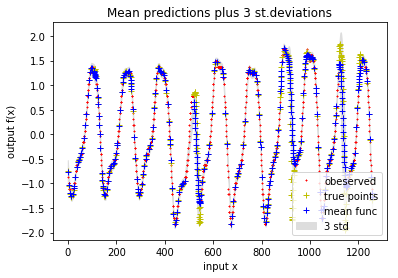

<type 'numpy.float64'>
kernel =  Mat (15.0, 1.0, 0.1)
hyperparams = 15.00, 1.0000, 0.1000. -LMS = -644.463650 
RMS error =  0.3830355110529022
- Log marginal likelihood =  -644.4636496678316
- LogProb mean is: -2.495720596915047 



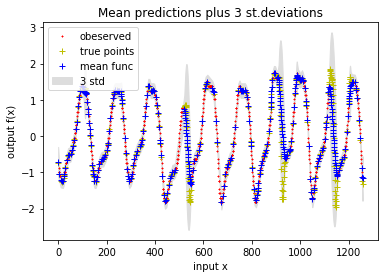

<type 'numpy.float64'>
kernel =  Per (15.0, 1.0, 1, 0.1)
hyperparams = 15.00, 1.0000, 0.1000. -LMS = 44586.909249 
RMS error =  1.1289460080040312
- Log marginal likelihood =  44586.90924895243
- LogProb mean is: -3.6787622015339756 



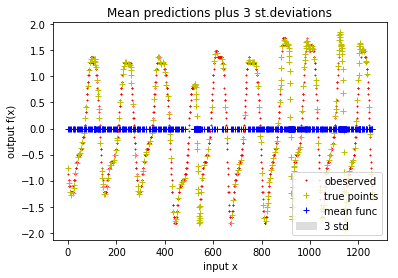

<type 'numpy.float64'>
kernel =  RQ (15.0, 1.0, 1, 0.1)
hyperparams = 15.00, 1.0000, 0.1000. -LMS = -838.984985 
RMS error =  0.36681669389721683
- Log marginal likelihood =  -838.9849848797986
- LogProb mean is: -2.963598385417152 



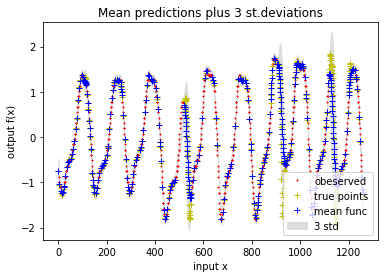

<type 'numpy.float64'>
kernel =  RQ_and_PC (15.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1)


KeyboardInterrupt: 

In [18]:
# Test all my kernels work with optimise function
plt.clf
hyp_opt = np.array([9.350e+01, 1.030e+00, 8.292e-01, 1.031e+00, 1.006e+00,3.47e-02]) #optimised below
hyps = [(15.0, 1.0, 1e-1), (15.0, 1.0, 1, 1e-1), (15.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-1), hyp_opt.reshape(6,1)]
arguments = [0, 0, 1, 1, 2, 3]
for kernel, i in zip(["SE", "Mat", "Per", "RQ", "RQ_and_PC", "M32_and_PC"], arguments):
    hyp = hyps[i]
    print "kernel = ", kernel, hyp
    f_to_optimise(hyp, kernel, X, Xtest, y, ytrue, True)

In [425]:
lengthscales = np.linspace(15, 20, 10)
variances = np.linspace(0.5, 1.4, 10)

LMLs = np.zeros((len(variances), len(lengthscales)))

for v in xrange(len(variances)):
    for l in xrange(len(lengthscales)):
        hyps = (lengthscales[l], variances[v], 1e-1)
        LMLs[v, l] = f_to_optimise(hyps, "SE", X, Xtest, y, ytrue, False)        

hyperparams = 15.00, 0.5000, 0.1000. -LMS = -866.951184 
hyperparams = 15.56, 0.5000, 0.1000. -LMS = -865.944786 
hyperparams = 16.11, 0.5000, 0.1000. -LMS = -863.296807 
hyperparams = 16.67, 0.5000, 0.1000. -LMS = -859.085184 
hyperparams = 17.22, 0.5000, 0.1000. -LMS = -853.435580 
hyperparams = 17.78, 0.5000, 0.1000. -LMS = -846.474602 
hyperparams = 18.33, 0.5000, 0.1000. -LMS = -838.263026 
hyperparams = 18.89, 0.5000, 0.1000. -LMS = -828.744281 
hyperparams = 19.44, 0.5000, 0.1000. -LMS = -817.736141 
hyperparams = 20.00, 0.5000, 0.1000. -LMS = -804.960405 
hyperparams = 15.00, 0.6000, 0.1000. -LMS = -887.908509 
hyperparams = 15.56, 0.6000, 0.1000. -LMS = -888.500332 
hyperparams = 16.11, 0.6000, 0.1000. -LMS = -887.543116 
hyperparams = 16.67, 0.6000, 0.1000. -LMS = -885.066105 
hyperparams = 17.22, 0.6000, 0.1000. -LMS = -881.168882 
hyperparams = 17.78, 0.6000, 0.1000. -LMS = -876.003090 
hyperparams = 18.33, 0.6000, 0.1000. -LMS = -869.716802 
hyperparams = 18.89, 0.6000, 0.

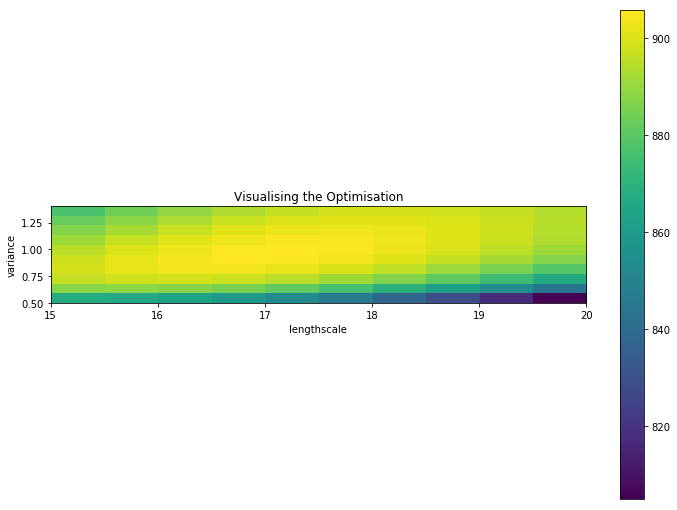

In [424]:
plt.imshow(-LMLs, extent=[min(lengthscales),max(lengthscales),min(variances),max(variances)], aspect=1, origin='lower')
plt.colorbar()
plt.xlabel("lengthscale"), plt.ylabel("variance"), plt.title("Visualising the Optimisation")
plt.show()

# Optimise -LML over hyperparameters

In [1199]:
kernel = "SE"
hyps = np.array((10.0, 1.0, 0.01)).reshape(3,1)
bnds =((0.1,None),(0.1,None),(0.01,None))

hyp_opt = scipy.optimize.minimize(f_to_optimise, hyps, method='L-BFGS-B', args = args, bounds=bnds, options={'maxiter':200})
print hyp_opt

# Mulitiple random (far appart in space) restarts and select the minimum of all to avoid local minima. 

hyperparams = 10.00, 1.0000, 0.0100. -LMS = 1907.099173 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = 1907.099174 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = 1907.099173 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = 1907.091100 
hyperparams = 10.00, 1.0000, 1.0100. -LMS = 984.424233 
hyperparams = 10.00, 1.0000, 1.0100. -LMS = 984.424233 
hyperparams = 10.00, 1.0000, 1.0100. -LMS = 984.424233 
hyperparams = 10.00, 1.0000, 1.0100. -LMS = 984.424241 
hyperparams = 10.00, 1.0000, 1.0090. -LMS = 983.599089 
hyperparams = 10.00, 1.0000, 1.0090. -LMS = 983.599089 
hyperparams = 10.00, 1.0000, 1.0090. -LMS = 983.599090 
hyperparams = 10.00, 1.0000, 1.0090. -LMS = 983.599098 
hyperparams = 10.00, 0.9998, 1.0050. -LMS = 980.290559 
hyperparams = 10.00, 0.9998, 1.0050. -LMS = 980.290559 
hyperparams = 10.00, 0.9998, 1.0050. -LMS = 980.290559 
hyperparams = 10.00, 0.9998, 1.0050. -LMS = 980.290567 
hyperparams = 10.00, 0.9991, 0.9888. -LMS = 966.927370 
hyperparams = 10.00, 0.9991, 0.9888. -LMS = 

hyperparams = 10.25, 0.6245, 0.0367. -LMS = -1290.479175 
hyperparams = 10.44, 0.6138, 0.0376. -LMS = -1293.000355 
hyperparams = 10.44, 0.6138, 0.0376. -LMS = -1293.000355 
hyperparams = 10.44, 0.6138, 0.0376. -LMS = -1293.000355 
hyperparams = 10.44, 0.6138, 0.0376. -LMS = -1293.000331 
hyperparams = 10.88, 0.6068, 0.0391. -LMS = -1298.783551 
hyperparams = 10.88, 0.6068, 0.0391. -LMS = -1298.783551 
hyperparams = 10.88, 0.6068, 0.0391. -LMS = -1298.783551 
hyperparams = 10.88, 0.6068, 0.0391. -LMS = -1298.783516 
hyperparams = 11.82, 0.6124, 0.0408. -LMS = -1310.345824 
hyperparams = 11.82, 0.6124, 0.0408. -LMS = -1310.345824 
hyperparams = 11.82, 0.6124, 0.0408. -LMS = -1310.345824 
hyperparams = 11.82, 0.6124, 0.0408. -LMS = -1310.345779 
hyperparams = 13.38, 0.6083, 0.0416. -LMS = -1325.530744 
hyperparams = 13.38, 0.6083, 0.0416. -LMS = -1325.530745 
hyperparams = 13.38, 0.6083, 0.0416. -LMS = -1325.530746 
hyperparams = 13.38, 0.6083, 0.0416. -LMS = -1325.530699 
hyperparams = 

In [45]:
kernel = "RQ_and_PC"
hyps = np.array((15.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.01)).reshape(7,1)
bnds =((0.1,None),(0.1,None),(0.1,None),(0.1,None),(0.1,None),(0.1,None),(0.01,None))

args = (kernel, X, Xtest, y, ytrue, False)
hyp_opt = scipy.optimize.minimize(f_to_optimise, hyps, method='L-BFGS-B', args = args, bounds=bnds, options={'maxiter':200})

print hyp_opt

hyperparams = 15.00, 1.0000, 0.0100. -LMS = 1598.925476 
hyperparams = 15.00, 1.0000, 0.0100. -LMS = 1598.925476 
hyperparams = 15.00, 1.0000, 0.0100. -LMS = 1598.925475 
hyperparams = 15.00, 1.0000, 0.0100. -LMS = 1598.925479 
hyperparams = 15.00, 1.0000, 0.0100. -LMS = 1598.925476 
hyperparams = 15.00, 1.0000, 0.0100. -LMS = 1598.925475 
hyperparams = 15.00, 1.0000, 0.0100. -LMS = 1598.925476 
hyperparams = 15.00, 1.0000, 0.0100. -LMS = 1598.918121 
hyperparams = 15.00, 1.0001, 1.0100. -LMS = 965.478968 
hyperparams = 15.00, 1.0001, 1.0100. -LMS = 965.478968 
hyperparams = 15.00, 1.0001, 1.0100. -LMS = 965.478968 
hyperparams = 15.00, 1.0001, 1.0100. -LMS = 965.478968 
hyperparams = 15.00, 1.0001, 1.0100. -LMS = 965.478968 
hyperparams = 15.00, 1.0001, 1.0100. -LMS = 965.478968 
hyperparams = 15.00, 1.0001, 1.0100. -LMS = 965.478968 
hyperparams = 15.00, 1.0001, 1.0100. -LMS = 965.478976 
hyperparams = 15.00, 1.0000, 0.3436. -LMS = 83.407452 
hyperparams = 15.00, 1.0000, 0.3436. -LMS

hyperparams = 15.00, 0.9939, 0.0347. -LMS = -1302.335839 
hyperparams = 15.00, 0.9939, 0.0347. -LMS = -1302.335838 
hyperparams = 15.00, 0.9939, 0.0347. -LMS = -1302.335840 
hyperparams = 15.00, 0.9939, 0.0347. -LMS = -1302.335839 
hyperparams = 15.00, 0.9939, 0.0347. -LMS = -1302.335838 
hyperparams = 15.00, 0.9939, 0.0347. -LMS = -1302.335839 
hyperparams = 15.00, 0.9939, 0.0347. -LMS = -1302.335839 
hyperparams = 15.00, 0.9926, 0.0350. -LMS = -1302.519204 
hyperparams = 15.00, 0.9926, 0.0350. -LMS = -1302.519204 
hyperparams = 15.00, 0.9926, 0.0350. -LMS = -1302.519203 
hyperparams = 15.00, 0.9926, 0.0350. -LMS = -1302.519205 
hyperparams = 15.00, 0.9926, 0.0350. -LMS = -1302.519204 
hyperparams = 15.00, 0.9926, 0.0350. -LMS = -1302.519203 
hyperparams = 15.00, 0.9926, 0.0350. -LMS = -1302.519204 
hyperparams = 15.00, 0.9926, 0.0350. -LMS = -1302.519200 
hyperparams = 15.00, 0.9898, 0.0353. -LMS = -1302.879273 
hyperparams = 15.00, 0.9898, 0.0353. -LMS = -1302.879273 
hyperparams = 

hyperparams = 15.06, 0.8199, 0.0347. -LMS = -1324.363897 
hyperparams = 15.06, 0.8292, 0.0349. -LMS = -1324.842396 
hyperparams = 15.06, 0.8292, 0.0349. -LMS = -1324.842396 
hyperparams = 15.06, 0.8292, 0.0349. -LMS = -1324.842396 
hyperparams = 15.06, 0.8292, 0.0349. -LMS = -1324.842396 
hyperparams = 15.06, 0.8292, 0.0349. -LMS = -1324.842396 
hyperparams = 15.06, 0.8292, 0.0349. -LMS = -1324.842396 
hyperparams = 15.06, 0.8292, 0.0349. -LMS = -1324.842394 
hyperparams = 15.06, 0.8292, 0.0349. -LMS = -1324.842395 
hyperparams = 15.07, 0.8122, 0.0346. -LMS = -1325.298983 
hyperparams = 15.07, 0.8122, 0.0346. -LMS = -1325.298983 
hyperparams = 15.07, 0.8122, 0.0346. -LMS = -1325.298983 
hyperparams = 15.07, 0.8122, 0.0346. -LMS = -1325.298983 
hyperparams = 15.07, 0.8122, 0.0346. -LMS = -1325.298983 
hyperparams = 15.07, 0.8122, 0.0346. -LMS = -1325.298983 
hyperparams = 15.07, 0.8122, 0.0346. -LMS = -1325.298979 
hyperparams = 15.07, 0.8122, 0.0346. -LMS = -1325.298986 
hyperparams = 

hyperparams = 16.91, 0.9638, 0.0362. -LMS = -1361.311512 
hyperparams = 16.91, 0.9638, 0.0362. -LMS = -1361.311512 
hyperparams = 16.91, 0.9638, 0.0362. -LMS = -1361.311512 
hyperparams = 16.94, 0.9639, 0.0362. -LMS = -1361.301925 
hyperparams = 16.94, 0.9639, 0.0362. -LMS = -1361.301925 
hyperparams = 16.94, 0.9639, 0.0362. -LMS = -1361.301925 
hyperparams = 16.94, 0.9639, 0.0362. -LMS = -1361.301925 
hyperparams = 16.94, 0.9639, 0.0362. -LMS = -1361.301925 
hyperparams = 16.94, 0.9639, 0.0362. -LMS = -1361.301925 
hyperparams = 16.94, 0.9639, 0.0362. -LMS = -1361.301925 
hyperparams = 16.94, 0.9639, 0.0362. -LMS = -1361.301926 
hyperparams = 16.92, 0.9638, 0.0362. -LMS = -1361.311508 
hyperparams = 16.92, 0.9638, 0.0362. -LMS = -1361.311508 
hyperparams = 16.92, 0.9638, 0.0362. -LMS = -1361.311508 
hyperparams = 16.92, 0.9638, 0.0362. -LMS = -1361.311508 
hyperparams = 16.92, 0.9638, 0.0362. -LMS = -1361.311508 
hyperparams = 16.92, 0.9638, 0.0362. -LMS = -1361.311508 
hyperparams = 

hyperparams = 16.90, 0.9628, 0.0363. -LMS = -1361.312985 
hyperparams = 16.90, 0.9628, 0.0363. -LMS = -1361.312985 
hyperparams = 16.90, 0.9628, 0.0363. -LMS = -1361.312985 
hyperparams = 16.90, 0.9628, 0.0363. -LMS = -1361.312985 
hyperparams = 16.90, 0.9628, 0.0363. -LMS = -1361.312985 
hyperparams = 16.90, 0.9627, 0.0362. -LMS = -1361.313477 
hyperparams = 16.90, 0.9627, 0.0362. -LMS = -1361.313477 
hyperparams = 16.90, 0.9627, 0.0362. -LMS = -1361.313477 
hyperparams = 16.90, 0.9627, 0.0362. -LMS = -1361.313477 
hyperparams = 16.90, 0.9627, 0.0362. -LMS = -1361.313477 
hyperparams = 16.90, 0.9627, 0.0362. -LMS = -1361.313477 
hyperparams = 16.90, 0.9627, 0.0362. -LMS = -1361.313477 
hyperparams = 16.90, 0.9627, 0.0362. -LMS = -1361.313477 
hyperparams = 16.90, 0.9625, 0.0362. -LMS = -1361.314038 
hyperparams = 16.90, 0.9625, 0.0362. -LMS = -1361.314038 
hyperparams = 16.90, 0.9625, 0.0362. -LMS = -1361.314038 
hyperparams = 16.90, 0.9625, 0.0362. -LMS = -1361.314038 
hyperparams = 

hyperparams = 19.47, 1.0229, 0.0362. -LMS = -1363.191836 
hyperparams = 19.47, 1.0229, 0.0362. -LMS = -1363.191836 
hyperparams = 19.47, 1.0229, 0.0362. -LMS = -1363.191836 
hyperparams = 19.47, 1.0229, 0.0362. -LMS = -1363.191836 
hyperparams = 19.47, 1.0229, 0.0362. -LMS = -1363.191836 
hyperparams = 19.47, 1.0229, 0.0362. -LMS = -1363.191836 
hyperparams = 19.47, 1.0229, 0.0362. -LMS = -1363.191835 
hyperparams = 19.75, 1.0288, 0.0362. -LMS = -1363.211534 
hyperparams = 19.75, 1.0288, 0.0362. -LMS = -1363.211534 
hyperparams = 19.75, 1.0288, 0.0362. -LMS = -1363.211534 
hyperparams = 19.75, 1.0288, 0.0362. -LMS = -1363.211534 
hyperparams = 19.75, 1.0288, 0.0362. -LMS = -1363.211534 
hyperparams = 19.75, 1.0288, 0.0362. -LMS = -1363.211534 
hyperparams = 19.75, 1.0288, 0.0362. -LMS = -1363.211534 
hyperparams = 19.75, 1.0288, 0.0362. -LMS = -1363.211533 
hyperparams = 20.12, 1.0267, 0.0361. -LMS = -1363.221325 
hyperparams = 20.12, 1.0267, 0.0361. -LMS = -1363.221325 
hyperparams = 

hyperparams = 23.38, 0.9983, 0.0358. -LMS = -1363.492302 
hyperparams = 23.38, 0.9983, 0.0358. -LMS = -1363.492315 
hyperparams = 22.35, 1.0020, 0.0360. -LMS = -1363.773822 
hyperparams = 22.35, 1.0020, 0.0360. -LMS = -1363.773822 
hyperparams = 22.35, 1.0020, 0.0360. -LMS = -1363.773822 
hyperparams = 22.35, 1.0020, 0.0360. -LMS = -1363.773822 
hyperparams = 22.35, 1.0020, 0.0360. -LMS = -1363.773822 
hyperparams = 22.35, 1.0020, 0.0360. -LMS = -1363.773822 
hyperparams = 22.35, 1.0020, 0.0360. -LMS = -1363.773820 
hyperparams = 22.35, 1.0020, 0.0360. -LMS = -1363.773822 
hyperparams = 23.58, 1.0075, 0.0358. -LMS = -1363.655187 
hyperparams = 23.58, 1.0075, 0.0358. -LMS = -1363.655187 
hyperparams = 23.58, 1.0075, 0.0358. -LMS = -1363.655187 
hyperparams = 23.58, 1.0075, 0.0358. -LMS = -1363.655187 
hyperparams = 23.58, 1.0075, 0.0358. -LMS = -1363.655187 
hyperparams = 23.58, 1.0075, 0.0358. -LMS = -1363.655187 
hyperparams = 23.58, 1.0075, 0.0358. -LMS = -1363.655178 
hyperparams = 

In [46]:
kernel = "M32_and_PC"
hyps = np.array((10.0, 1.0, 1.0, 1.0, 1.0, 0.01)).reshape(6,1)
bnds =((0.1,None),(0.1,None),(0.1,None),(0.1,None),(0.1,None),(0.01,None))

args = (kernel, X, Xtest, y, ytrue, False)
hyp_opt = scipy.optimize.minimize(f_to_optimise, hyps, method='L-BFGS-B', args = args, bounds=bnds, options={'maxiter':200})

print hyp_opt

hyperparams = 10.00, 1.0000, 0.0100. -LMS = -816.007898 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = -816.007898 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = -816.007893 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = -816.007898 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = -816.007893 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = -816.007898 
hyperparams = 10.00, 1.0000, 0.0100. -LMS = -816.007903 
hyperparams = 10.11, 0.9983, 1.0043. -LMS = 1005.971343 
hyperparams = 10.11, 0.9983, 1.0043. -LMS = 1005.971343 
hyperparams = 10.11, 0.9983, 1.0043. -LMS = 1005.971344 
hyperparams = 10.11, 0.9983, 1.0043. -LMS = 1005.971343 
hyperparams = 10.11, 0.9983, 1.0043. -LMS = 1005.971344 
hyperparams = 10.11, 0.9983, 1.0043. -LMS = 1005.971343 
hyperparams = 10.11, 0.9983, 1.0043. -LMS = 1005.971351 
hyperparams = 10.01, 0.9999, 0.0583. -LMS = -670.684481 
hyperparams = 10.01, 0.9999, 0.0583. -LMS = -670.684482 
hyperparams = 10.01, 0.9999, 0.0583. -LMS = -670.684477 
hyperparams = 10.01, 0.9999, 0.

hyperparams = 10.18, 0.6837, 0.0262. -LMS = -1041.758626 
hyperparams = 10.18, 0.6837, 0.0262. -LMS = -1041.758625 
hyperparams = 10.18, 0.6837, 0.0262. -LMS = -1041.758633 
hyperparams = 10.18, 0.6837, 0.0262. -LMS = -1041.758634 
hyperparams = 10.40, 0.7002, 0.0256. -LMS = -1046.646251 
hyperparams = 10.40, 0.7002, 0.0256. -LMS = -1046.646252 
hyperparams = 10.40, 0.7002, 0.0256. -LMS = -1046.646250 
hyperparams = 10.40, 0.7002, 0.0256. -LMS = -1046.646251 
hyperparams = 10.40, 0.7002, 0.0256. -LMS = -1046.646250 
hyperparams = 10.40, 0.7002, 0.0256. -LMS = -1046.646263 
hyperparams = 10.40, 0.7002, 0.0256. -LMS = -1046.646264 
hyperparams = 10.93, 0.7273, 0.0250. -LMS = -1058.115259 
hyperparams = 10.93, 0.7273, 0.0250. -LMS = -1058.115259 
hyperparams = 10.93, 0.7273, 0.0250. -LMS = -1058.115257 
hyperparams = 10.93, 0.7273, 0.0250. -LMS = -1058.115259 
hyperparams = 10.93, 0.7273, 0.0250. -LMS = -1058.115257 
hyperparams = 10.93, 0.7273, 0.0250. -LMS = -1058.115275 
hyperparams = 

hyperparams = 68.58, 0.9570, 0.0348. -LMS = -1369.036134 
hyperparams = 68.58, 0.9570, 0.0348. -LMS = -1369.036086 
hyperparams = 77.46, 0.9635, 0.0352. -LMS = -1368.970392 
hyperparams = 77.46, 0.9635, 0.0352. -LMS = -1368.970392 
hyperparams = 77.46, 0.9635, 0.0352. -LMS = -1368.970392 
hyperparams = 77.46, 0.9635, 0.0352. -LMS = -1368.970392 
hyperparams = 77.46, 0.9635, 0.0352. -LMS = -1368.970392 
hyperparams = 77.46, 0.9635, 0.0352. -LMS = -1368.970343 
hyperparams = 77.46, 0.9635, 0.0352. -LMS = -1368.970383 
hyperparams = 72.46, 0.9598, 0.0350. -LMS = -1370.281963 
hyperparams = 72.46, 0.9598, 0.0350. -LMS = -1370.281963 
hyperparams = 72.46, 0.9598, 0.0350. -LMS = -1370.281963 
hyperparams = 72.46, 0.9598, 0.0350. -LMS = -1370.281963 
hyperparams = 72.46, 0.9598, 0.0350. -LMS = -1370.281963 
hyperparams = 72.46, 0.9598, 0.0350. -LMS = -1370.281946 
hyperparams = 72.46, 0.9598, 0.0350. -LMS = -1370.281956 
hyperparams = 75.26, 0.9600, 0.0348. -LMS = -1370.908476 
hyperparams = 

hyperparams = 91.62, 1.0753, 0.0346. -LMS = -1373.357532 
hyperparams = 91.62, 1.0753, 0.0346. -LMS = -1373.357532 
hyperparams = 91.62, 1.0753, 0.0346. -LMS = -1373.357532 
hyperparams = 91.62, 1.0753, 0.0346. -LMS = -1373.357532 
hyperparams = 91.62, 1.0753, 0.0346. -LMS = -1373.357532 
hyperparams = 91.62, 1.0753, 0.0346. -LMS = -1373.357533 
hyperparams = 91.62, 1.0753, 0.0346. -LMS = -1373.357532 
hyperparams = 91.63, 1.0755, 0.0346. -LMS = -1373.359256 
hyperparams = 91.63, 1.0755, 0.0346. -LMS = -1373.359256 
hyperparams = 91.63, 1.0755, 0.0346. -LMS = -1373.359256 
hyperparams = 91.63, 1.0755, 0.0346. -LMS = -1373.359256 
hyperparams = 91.63, 1.0755, 0.0346. -LMS = -1373.359256 
hyperparams = 91.63, 1.0755, 0.0346. -LMS = -1373.359259 
hyperparams = 91.63, 1.0755, 0.0346. -LMS = -1373.359256 
hyperparams = 91.58, 1.0748, 0.0346. -LMS = -1373.365357 
hyperparams = 91.58, 1.0748, 0.0346. -LMS = -1373.365357 
hyperparams = 91.58, 1.0748, 0.0346. -LMS = -1373.365357 
hyperparams = 

hyperparams = 93.51, 1.0303, 0.0348. -LMS = -1374.165770 
hyperparams = 93.51, 1.0303, 0.0348. -LMS = -1374.165770 
hyperparams = 93.51, 1.0303, 0.0348. -LMS = -1374.165770 
hyperparams = 93.51, 1.0303, 0.0348. -LMS = -1374.165770 
hyperparams = 93.51, 1.0303, 0.0348. -LMS = -1374.165770 
hyperparams = 93.32, 1.0890, 0.0331. -LMS = -1368.530914 
hyperparams = 93.32, 1.0890, 0.0331. -LMS = -1368.530914 
hyperparams = 93.32, 1.0890, 0.0331. -LMS = -1368.530914 
hyperparams = 93.32, 1.0890, 0.0331. -LMS = -1368.530915 
hyperparams = 93.32, 1.0890, 0.0331. -LMS = -1368.530914 
hyperparams = 93.32, 1.0890, 0.0331. -LMS = -1368.530818 
hyperparams = 93.32, 1.0890, 0.0331. -LMS = -1368.530933 
hyperparams = 93.51, 1.0304, 0.0348. -LMS = -1374.165771 
hyperparams = 93.51, 1.0304, 0.0348. -LMS = -1374.165771 
hyperparams = 93.51, 1.0304, 0.0348. -LMS = -1374.165771 
hyperparams = 93.51, 1.0304, 0.0348. -LMS = -1374.165771 
hyperparams = 93.51, 1.0304, 0.0348. -LMS = -1374.165771 
hyperparams = 

In [1200]:
# Test the optimal works on the full data
hyps = hyp_opt.reshape(6,1)
# hyps = np.array((93.5, 1.0, 0.83, 1.0, 1.0, 0.034)).reshape(6,1)
f_to_optimise(hyps, "M32_and_PC", X, Xtest, y, ytrue, False)


AttributeError: reshape

# Optimise using gradients:

We are looking to maximise the log probability of: $p(\boldsymbol{y} \mid X, \Theta)$

$$
log p(\boldsymbol{y} \mid X, \Theta) = -\frac{1}{2}\boldsymbol{y}^T (K+\sigma^2_n I)^{-1} - \frac{1}{2}log \mid K+\sigma^2_n I \mid - \frac{n}{2}log2\pi .
$$

$$
\begin{align}
\frac{\partial}{\partial \theta_j} log p(\boldsymbol{y} \mid X, \Theta) 
= &
\frac{1}{2}\boldsymbol{y}^T K^{-1} \frac{\partial K}{\partial \theta_j}K^{-1}\boldsymbol{y} - \frac{1}{2}\text{tr}\big(K^{-1} \frac{\partial K}{\partial \theta_j}\big) \\
= & 
\frac{1}{2}\text{tr}\Big( (\boldsymbol{\alpha} \boldsymbol{\alpha}^T - K^{-1} ) \frac{\partial K}{\partial \theta_j}\Big), \text{ where } \boldsymbol{\alpha} = K^{-1}\boldsymbol{y}.
\end{align}
$$
where $\frac{\partial K}{\partial \theta_j}$ is a matrix of elementwise derivatives. There is a nice discussion [here](https://math.stackexchange.com/questions/1030534/gradients-of-marginal-likelihood-of-gaussian-process-with-squared-exponential-co): 

So, derivatives: 
$$
\frac{\partial K}{\partial \sigma_l} = \frac{\sigma^{2}_{f}(x - x')^2}{l^3} exp (-\frac{1}{2l^2}(x - x')^2) ,
$$
and 
$$
\frac{\partial K}{\partial \sigma_f} = 2\sigma_{f} exp (-\frac{1}{2l^2}(x - x')^2).
$$

In [82]:
import numpy as np

def optimise_with_grad(hyp, *args):

    try:
        kernel, X, Xtest, y, ytrue, vis = args
    except ValueError as e:
        kernel, X, Xtest, y, ytrue, vis = args[0]
    
    N = len(X)                    # number of train points   
    mu = y.mean()                 # training set mean
    #sigma_n = 0.03672107#0.1
    sigma_n = hyp[-1]
    
    K, Kstar, Kstarstar = select_kernel(kernel, X, Xtest, hyp[:-1])
    
    # compute the Posterior distribution (mean and covariance)
    diag = sigma_n**2*np.eye(N)
    L = make_sure_cholesky(K, diag)            
    m = np.linalg.solve(L, y-mu)
    alpha = np.linalg.solve(L.T, m)
    mu_star = np.dot(Kstar.T, alpha) + mu
    
    #Log marginal likelihood
    LML = -0.5*np.dot(y.T-mu, alpha) - sum(np.log(np.diag(L))) - 0.5*N*np.log(2*np.pi)
    
    print "hyperparams = %0.2f, %0.4f, %0.4f. -LMS = %f " % (hyp[0], hyp[1], hyp[2], -LML)
    return -LML

def SE_kernel_simple(a, b, args):
    """GP squared exponential kernel"""
    l, sig = args
    sqd = np.subtract.outer(a, b)**2  
    K = (sig**2)*np.exp((-sqd/float(2*l**2)))    
    return K

def make_sure_cholesky(K, diag):
    flag = False
    while flag == False:
        try: 
            L = np.linalg.cholesky(K + diag)
            flag = True
        except np.linalg.LinAlgError as e:
            diag = diag+ np.eye(K.shape[0])*0.1    
    return L

def grad_MLL(x, *args):
    l, sigma_f, sigma_n = x
    
    try:
        kernel, X, Xtest, y, ytrue, vis = args
    except ValueError as e:
        kernel, X, Xtest, y, ytrue, vis = args[0]

    K = SE_kernel_simple(X, X, (l, sigma_f)) 
    diag = sigma_n**2*np.eye(N)
    L  = make_sure_cholesky(K, diag)

    m = np.linalg.solve(L, y-mu)
    alpha = np.linalg.solve(L.T, m).reshape(len(X), 1)

#     Kinv1 = np.linalg.inv(L.T)*np.linalg.inv(L.T)
#     Kinv1 = np.multiply(sp.linalg.lapack.clapack.dtrtri(L.T)[0], sp.linalg.lapack.clapack.dtrtri(L.T)[0])
    
    Kinv = np.linalg.inv(K+diag)
#     print Kinv[0][:10]
    
    left = np.matmul((y.T-mu), Kinv)
    sqdist = np.subtract.outer(X, X)**2 
    
    dK_theta_l = (sqdist*sigma_f**2) * (np.exp(-0.5*(sqdist/(l**2)))) * 1/ float(l**3)
    dK_theta_s = (2*sigma_f) * np.exp(-sqdist/float(2*l**2))
    dk_theta_sn = 2*sigma_n*np.eye(N)
    
    dK_theta = [dK_theta_l, dK_theta_s, dk_theta_sn]
    
    # Optimise each hyperparameter
    ret = np.asarray(np.ones(len(x)), dtype=np.float32) 
    for cnt, hyp in enumerate(x):
        first =  np.matmul(left, (np.matmul(dK_theta[cnt], alpha)))[0]                           # only multiply matrix-vec terms
        second = np.sum( [ np.dot(Kinv[d], dK_theta[cnt].T[d]) for d in xrange(Kinv.shape[0])])  # only compute diag terms
        ret[cnt] = -(0.5*first - 0.5*second)

    #     first = np.matmul(left, (np.matmul(dK_theta_s, alpha)))[0]                            # only multiply matrix-vec terms
    #     second = np.sum( [ np.dot(Kinv[d], dK_theta_s.T[d]) for d in xrange(Kinv.shape[0])])  # only compute diag terms
    #     ret[1] = -(0.5*first - 0.5*second)
      
    print "gradient at %0.2f, %0.2f, %0.2f is = (%0.4f, %0.4f, %0.4f)\n" % (l, sigma_f, sigma_n, ret[0], ret[1], ret[2])
    return ret


In [76]:
import numpy as np

## Check the Likelihood matches the minimum 
# hyp = np.asarray((15.27723164, 0.89970085, 0.0367210))   # MLE
hyp = np.asarray((12., 0.5, 0.1), dtype=np.float32) 

args = ("SE", X, Xtest, y, ytrue, False)
optimise_with_grad(hyp, args)

# ## Check the gradient function produces zero at the MLE 
"the gradient at %s is: %s" % (hyp, grad_MLL(hyp, args))

scipy.optimize.fmin_cg(optimise_with_grad, hyp, fprime=grad_MLL, args=args, maxiter=1000)

hyperparams = 12.00, 0.5000, 0.1000. -LMS = -845.155224 
gradient at 12.00, 0.50, 0.10 is = (-14.3774, -244.2126, 6919.0273)

gradient at 12.00, 0.50, 0.10 is = (-14.3774, -244.2126, 6919.0273)

hyperparams = 12.00, 0.5000, 0.1000. -LMS = -845.155224 
hyperparams = 12.00, 0.5356, -0.9094. -LMS = 893.739604 
gradient at 12.00, 0.54, -0.91 is = (-4.7948, -132.5991, -911.2614)

hyperparams = 12.00, 0.5083, -0.1364. -LMS = -623.566330 
gradient at 12.00, 0.51, -0.14 is = (-13.2333, -225.6401, -5461.7080)

hyperparams = 12.00, 0.5031, 0.0125. -LMS = 640.885931 
gradient at 12.00, 0.50, 0.01 is = (61.9191, -437.2011, -436680.5312)

hyperparams = 12.00, 0.5012, 0.0658. -LMS = -1109.218494 
gradient at 12.00, 0.50, 0.07 is = (-15.2226, -242.7846, 8393.0293)

hyperparams = 12.00, 0.5023, 0.0336. -LMS = -1305.904067 
gradient at 12.00, 0.50, 0.03 is = (-11.5289, -255.3642, -3187.6182)

hyperparams = 12.00, 0.5020, 0.0425. -LMS = -1289.457439 
gradient at 12.00, 0.50, 0.04 is = (-14.0287, -247.68

gradient at 13.72, 0.80, 0.04 is = (-7.3157, 2.8470, 35.5046)

hyperparams = 13.73, 0.7931, 0.0363. -LMS = -1349.444217 
gradient at 13.73, 0.79, 0.04 is = (-7.2464, 1.6937, 156.2884)

hyperparams = 13.75, 0.7855, 0.0366. -LMS = -1349.492725 
gradient at 13.75, 0.79, 0.04 is = (-7.0791, -1.1601, 438.8293)

hyperparams = 13.78, 0.7732, 0.0364. -LMS = -1349.680650 
gradient at 13.78, 0.77, 0.04 is = (-6.5826, -6.5493, 275.7863)

hyperparams = 13.81, 0.7564, 0.0363. -LMS = -1349.769829 
gradient at 13.81, 0.76, 0.04 is = (-5.8869, -14.6034, 46.1247)

hyperparams = 13.82, 0.7598, 0.0254. -LMS = -1224.086887 
gradient at 13.82, 0.76, 0.03 is = (2.4384, -30.6360, -31505.3789)

hyperparams = 13.81, 0.7564, 0.0362. -LMS = -1349.770889 
gradient at 13.81, 0.76, 0.04 is = (-5.8637, -14.6482, -17.1531)

hyperparams = 13.81, 0.7565, 0.0362. -LMS = -1349.772543 
gradient at 13.81, 0.76, 0.04 is = (-5.8542, -14.6092, -51.1137)

hyperparams = 13.81, 0.7567, 0.0362. -LMS = -1349.773238 
gradient at 13

gradient at 14.07, 0.79, 0.04 is = (-5.0321, -6.2132, -39.6554)

hyperparams = 14.07, 0.7910, 0.0363. -LMS = -1351.502476 
gradient at 14.07, 0.79, 0.04 is = (-5.0373, -6.2116, -25.1251)

hyperparams = 14.07, 0.7911, 0.0363. -LMS = -1351.503132 
gradient at 14.07, 0.79, 0.04 is = (-5.0384, -6.1893, -25.0507)

hyperparams = 14.07, 0.7914, 0.0363. -LMS = -1351.505751 
gradient at 14.07, 0.79, 0.04 is = (-5.0427, -6.1001, -24.7540)

hyperparams = 14.07, 0.7924, 0.0363. -LMS = -1351.515999 
gradient at 14.07, 0.79, 0.04 is = (-5.0597, -5.7447, -23.5586)

hyperparams = 14.07, 0.7965, 0.0363. -LMS = -1351.553532 
gradient at 14.07, 0.80, 0.04 is = (-5.1276, -4.3451, -18.8162)

hyperparams = 14.08, 0.8128, 0.0363. -LMS = -1351.650694 
gradient at 14.08, 0.81, 0.04 is = (-5.3933, 0.9219, -0.1560)

hyperparams = 14.14, 0.8083, 0.0378. -LMS = -1350.749734 
gradient at 14.14, 0.81, 0.04 is = (-5.6086, -0.3550, 1569.3348)

hyperparams = 14.09, 0.8123, 0.0365. -LMS = -1351.668320 
gradient at 14.09

gradient at 14.67, 0.83, 0.04 is = (-2.3499, -4.6214, 37.3351)

hyperparams = 14.71, 0.8401, 0.0367. -LMS = -1354.062734 
gradient at 14.71, 0.84, 0.04 is = (-2.3092, -3.5310, 211.0300)

hyperparams = 14.81, 0.8539, 0.0371. -LMS = -1354.155207 
gradient at 14.81, 0.85, 0.04 is = (-2.2088, -1.1931, 598.8713)

hyperparams = 14.97, 0.8780, 0.0370. -LMS = -1354.530126 
gradient at 14.97, 0.88, 0.04 is = (-1.6311, 1.5596, 400.9052)

hyperparams = 15.24, 0.9175, 0.0367. -LMS = -1354.755329 
gradient at 15.24, 0.92, 0.04 is = (-0.6251, 4.8076, 65.3350)

hyperparams = 15.24, 0.9162, 0.0183. -LMS = -723.870811 
gradient at 15.24, 0.92, 0.02 is = (29.7149, -47.9276, -127068.8750)

hyperparams = 15.24, 0.9173, 0.0342. -LMS = -1350.585514 
gradient at 15.24, 0.92, 0.03 is = (0.8863, 1.8634, -3510.2224)

hyperparams = 15.24, 0.9175, 0.0367. -LMS = -1354.757184 
gradient at 15.24, 0.92, 0.04 is = (-0.5971, 4.7522, 2.8614)

hyperparams = 15.24, 0.9169, 0.0363. -LMS = -1354.690434 
gradient at 15.24, 

gradient at 15.27, 0.90, 0.04 is = (-0.0069, -0.2956, -45.5740)

hyperparams = 15.27, 0.8985, 0.0367. -LMS = -1354.809731 
gradient at 15.27, 0.90, 0.04 is = (-0.0501, -0.0241, 0.1983)

hyperparams = 15.27, 0.8985, 0.0366. -LMS = -1354.802366 
gradient at 15.27, 0.90, 0.04 is = (0.0093, -0.1411, -131.6591)

hyperparams = 15.27, 0.8985, 0.0367. -LMS = -1354.809731 
gradient at 15.27, 0.90, 0.04 is = (-0.0500, -0.0243, -0.0143)

hyperparams = 15.27, 0.8985, 0.0367. -LMS = -1354.809731 
gradient at 15.27, 0.90, 0.04 is = (-0.0500, -0.0243, -0.0146)

hyperparams = 15.27, 0.8985, 0.0367. -LMS = -1354.809731 
gradient at 15.27, 0.90, 0.04 is = (-0.0500, -0.0241, -0.0101)

hyperparams = 15.27, 0.8985, 0.0367. -LMS = -1354.809731 
gradient at 15.27, 0.90, 0.04 is = (-0.0500, -0.0232, 0.0073)

hyperparams = 15.27, 0.8985, 0.0367. -LMS = -1354.809733 
gradient at 15.27, 0.90, 0.04 is = (-0.0502, -0.0198, 0.0718)

hyperparams = 15.27, 0.8986, 0.0367. -LMS = -1354.809741 
gradient at 15.27, 0.90, 

gradient at 15.28, 0.90, 0.04 is = (-0.0006, 0.0000, -0.0031)

hyperparams = 15.28, 0.8997, 0.0367. -LMS = -1354.810033 
gradient at 15.28, 0.90, 0.04 is = (-0.0006, 0.0000, 0.0012)

hyperparams = 15.28, 0.8997, 0.0367. -LMS = -1354.810033 
gradient at 15.28, 0.90, 0.04 is = (-0.0006, 0.0000, 0.0012)

hyperparams = 15.28, 0.8997, 0.0367. -LMS = -1354.810033 
gradient at 15.28, 0.90, 0.04 is = (-0.0006, 0.0000, 0.0012)

hyperparams = 15.28, 0.8997, 0.0367. -LMS = -1354.810033 
gradient at 15.28, 0.90, 0.04 is = (-0.0006, 0.0000, 0.0012)

hyperparams = 15.28, 0.8997, 0.0367. -LMS = -1354.810033 
gradient at 15.28, 0.90, 0.04 is = (-0.0006, 0.0000, 0.0012)

hyperparams = 15.28, 0.8997, 0.0367. -LMS = -1354.810033 
gradient at 15.28, 0.90, 0.04 is = (-0.0006, 0.0000, 0.0012)

hyperparams = 15.28, 0.8997, 0.0367. -LMS = -1354.810033 
gradient at 15.28, 0.90, 0.04 is = (-0.0006, 0.0000, 0.0012)

hyperparams = 15.28, 0.8997, 0.0367. -LMS = -1354.810033 
gradient at 15.28, 0.90, 0.04 is = (-0.

array([ 15.27689266,   0.89967811,   0.03672094], dtype=float32)

In [83]:
import autograd.numpy as np
from autograd import grad   

def f_to_optimise_with_autograd(hyp, *args):
    try:
        kernel, X, Xtest, y, ytrue, vis = args
    except ValueError as e:
        kernel, X, Xtest, y, ytrue, vis = args[0]
    
    N = len(X)                    # number of train points   
    mu = y.mean()                 # training set mean
    #sigma_n = 0.03672107 #0.1#hyp[-1]
    sigma_n = hyp[-1]
    
    K, Kstar, Kstarstar = select_kernel(kernel, X, Xtest, hyp[:-1])
   
    # compute the Posterior distribution (mean and covariance)
    diag = sigma_n**2*np.eye(N)
    L = make_sure_cholesky(K, diag)
           
    m = np.linalg.solve(L, y-mu)
    alpha = np.linalg.solve(L.T, m)
    mu_star = np.dot(Kstar.T, alpha) + mu

    # Root-Mean Square Error
    RMS = np.sqrt(((mu_star - ytrue) ** 2).mean())
    
    #Log marginal likelihood
    LML = -0.5*np.dot(y.T-mu, alpha) - sum(np.log(np.diag(L))) - 0.5*N*np.log(2*np.pi)
    
    print "LML = ", -LML
    return -LML

grad_func = grad(f_to_optimise_with_autograd)       # Obtain its gradient function

hyp = np.asarray((15.27723164,   0.89970085,   0.03672107))  # MLE
#hyp = np.asarray((12, 0.5, 0.1)) 
args = ("SE_grad", X, Xtest, y, ytrue, False)

print "the gradient at %s is: %s" % (hyp, grad_func(hyp, args))

LML =  Autograd ArrayNode with value -1354.8100327 and 1 progenitors(s)
the gradient at [ 15.27723164   0.89970085   0.03672107] is: [ 0.00113274 -0.00199017  0.00342712]


In [750]:
x0 = np.asarray((15.0, 0.1))  # Initial guess.  # optimal: 15.28, 0.8997

args = ("SE", X, Xtest, y, ytrue, False)
scipy.optimize.fmin_cg(optimise_with_grad, x0, fprime=grad_MLL, args=args, maxiter=1000)

753.240941448 -19499.5694249
hyperparams = 15.00, 0.1000. -LMS = 1414.616196 
hyperparams = 14.96, 1.1092. -LMS = -1349.386801 
-338.771141764 -4797.09530582
hyperparams = 15.04, 2.2674. -LMS = -1298.449971 
-563.742177408 -10516.8353138
hyperparams = 14.97, 1.2730. -LMS = -1342.877431 
-290.043232907 -5671.36826436
hyperparams = 14.96, 1.1412. -LMS = -1348.226787 
-279.88801902 -4996.24457069
hyperparams = 14.96, 1.1158. -LMS = -1349.153643 
-282.453988995 -4787.71263458
hyperparams = 14.96, 1.1106. -LMS = -1349.338225 
-266.15655127 -4626.94205637
hyperparams = 14.96, 1.1095. -LMS = -1349.376503 
-269.359388038 -4775.69515917
hyperparams = 14.96, 1.1093. -LMS = -1349.384643 
-531.015406119 -3777.23639982
hyperparams = 14.96, 1.1093. -LMS = -1349.386310 
-251.869060186 -4779.80797118
hyperparams = 14.96, 1.1093. -LMS = -1349.386698 
-140.347090694 -3559.8001254
hyperparams = 14.96, 1.1092. -LMS = -1349.386778 
-228.59642177 -4621.40959367
hyperparams = 14.96, 1.1092. -LMS = -1349.3867

array([ 14.9610142,   1.1092473])

# sequential prediction

Sequentially predict the next timepoint in a series. 

For efficiency, just update the Cholesky matrix with each new training point. No need to calculate K or L each time. 

Current Data frame: 

X  

Xtest

y_ = unnormalised y

ytrue_ = unnormalised y true

In [625]:
# cholesky update function
def chol_update(R_11, V_12, V_22, sigma_n=1e-1):
    """Cholesky update by a row/column described in Appendix A.1 here: http://bit.ly/2ycHy0C"""
    S_12 = np.linalg.solve(R_11.T, V_12) 
    S_22_ = (V_22 + sigma_n)  - np.dot(S_12.T, S_12)
    S_22 = np.sqrt(S_22_)   #     S_22 = cholesky(S_22_, sigma_n)   # For 1x1 V_22
    if math.isnan(S_22): S_22 = np.zeros((1,1))
    S = np.bmat([[R_11, S_12], [np.zeros((S_12.T.shape)), S_22]])
    return S #+ sigma_n*np.eye(S.shape[0])

def cholesky(K, sigma_n, lower=False):
    diag = sigma_n**2*np.eye(K.shape[0])
    flag = False
    while flag == False:
        try: 
            R = scipy.linalg.cholesky(K, lower=lower)
            flag = True
        except np.linalg.LinAlgError as e:
            print ".",
            K += diag
    return R

In [642]:
# Using all data up to time t (including t), predict the value at t (assuming noise)

hyps = (10.0, 1.0, 0.1)
lookahead = 0

# incrementally update the training set (X,y) and GT ytrue
seq_X, seq_y, ytrue = np.array([]), np.array([]), np.array([])

# print data['y'][:10]

for t, y in zip(data['timeline'], data['y']):
    testset = np.array(data['timeline'][t: t+1+lookahead])

    # add (t, y) to training data
    if ~np.isnan(y):
        seq_X = np.r_[seq_X, t]
        seq_y = np.r_[seq_y, y]
        ytrue = np.r_[ytrue, data['True tide height (m)'][t]]

#     print "\n", t, dat?a.y[t], ytrue_all[t], testset, y[testset]    
#     print seq_X, seq_y, ytrue

    

In [650]:
def sequential_predictions(hyps, *args):

#     hyps = (10.0, 1.0, 0.1) #(15.277, 0.8997, 0.036)  # from SE optimisation
    lookahead = 3                  # test on just the next one test point(s) 
    start_set_size = 4             # start with some training points
    old_seq_y = 0
    all_mu, all_std, all_RMS = [], [], []

    x_axis = xrange(start_set_size, len(data['timeline']))
    all_ytrue = data['True tide height (m)']

    for cnt, current_t in enumerate(x_axis):  # start with some trianing points

        print  cnt,
        lookahead_tests = np.array(data['timeline'][current_t:current_t+lookahead])
        seq_X = X[X < lookahead_tests.min()]

        #normalise y
        train_mean = y_[X < lookahead_tests.min()].mean()
        train_std = np.std(y_[X < lookahead_tests.min()])
        seq_y = (y_[X < lookahead_tests.min()] - train_mean)/ float(train_std)
        lookahead_ytrue = np.array( (all_ytrue[current_t:current_t+lookahead] - train_mean)/ float(train_std))

        args = hyps[:-1]
        sigma_n = hyps[-1]
        mu = seq_y.mean()

        # First iteration compute K and R
        if cnt == 0: 
            K = SE_kernel_simple(seq_X, seq_X, args) + sigma_n*np.eye(len(seq_X))
            R = cholesky(K, sigma_n)

        # Other iters just update R using Ks and Kss
        elif len(seq_y) != old_seq_y:
            try: 
                next_Ks = np.array(Ks[:,0]).reshape(old_seq_y, 1)
                nest_Kss = np.array(Kss[0,0]).reshape(1,1)
                R = chol_update(R, next_Ks, nest_Kss, sigma_n)
            except IndexError as e:
                R = chol_update(R, Ks, Kss, sigma_n)

            # Check the Cholesky update:
            #K = SE_kernel_simple(seq_X, seq_X, args) + sigma_n*np.eye(len(seq_X))
            #R = cholesky(K, sigma_n) 
            #print ">>", np.isclose(R, Rup)

        Ks = SE_kernel_simple(seq_X, lookahead_tests, args)
        Kss = SE_kernel_simple(lookahead_tests, lookahead_tests, args)

        m = np.linalg.solve(R.T, seq_y-mu)
        alpha = np.linalg.solve(R, m)

        # Calculate mu_star badly:
        #Kinv = np.linalg.inv(K + sigma_n*np.eye(K.shape[0]))
        #r = np.matmul(Kinv, seq_y.T)
        #mu_star_slow = np.matmul(Ks.T, r.reshape(r.shape[0], 1))

        mu_star = np.dot(Ks.T, alpha) + mu
        RMS = np.sqrt(((mu_star - lookahead_ytrue) ** 2).mean())

        all_mu.append(mu_star+train_mean)
        all_RMS.append(RMS)
        old_seq_y = len(seq_y)
        print ">", lookahead_ytrue, mu_star #seq_X, seq_y, mu_star

    #     LML = -0.5*np.dot(seq_y.T-mu, alpha) - sum(np.log(np.diag(R))) - 0.5*N*np.log(2*np.pi)
        v = np.linalg.solve(R.T, Ks)  
        v_star = np.diag(Kss) - np.sum(v**2, axis=0)
        v_std = np.sqrt(v_star)
        all_std.append(v_std) 
        
    #     sigma_star = v_star + sigma_n**2
    #     LogProb = 0.5*np.log(2*np.pi*(sigma_star**2)) + ((lookahead_ytrue - mu_star) ** 2)/2*sigma_star

    print "\nlookahead of %s, yields avg RMS = %s" %(lookahead, np.mean(all_RMS))
    return all_mu, all_std

hyps = (10.0, 1.0, 0.1)
all_mu, all_std = sequential_predictions(hyps)

 0 > [-1.34721936 -1.83711731 -2.32701526] [-0.3988555  -0.58356021 -0.75140618]
1 > [-1.50755672 -1.98997487 -2.47239303] [-0.67844891 -0.91913597 -1.13269881]
2 > [-1.98997487 -2.47239303 -2.7136021 ] [-0.91913597 -1.13269881 -1.3140638 ]
3 > [-1.66698715 -1.86310328 -2.05921942] [-1.18243062 -1.42936186 -1.63718326]
4 > [-1.56173762 -1.74914613 -2.0302589 ] [-1.25440125 -1.47422624 -1.65256978]
5 > [-1.59020439 -1.87082869 -1.96437013] [-1.25444959 -1.42845185 -1.56068369]
6 > [-1.4596009  -1.54300666 -1.62641243] [-1.31670868 -1.47754821 -1.59826407]
7 > [-1.54300666 -1.62641243 -1.62641243] [-1.47754821 -1.59826407 -1.67858827]
8 > [-1.39653589 -1.39653589 -1.55563492] [-1.37710691 -1.45867491 -1.50363095]
9 > [-1.2493901  -1.40556386 -1.40556386] [-1.25851015 -1.29765685 -1.30452374]
10 > [-1.30107648 -1.30107648 -1.37885822] [-1.13112935 -1.1305033  -1.10261549]
11 > [-1.22377576 -1.30188911 -1.22377576] [-1.00031404 -0.96574537 -0.90947071]
12 > [-1.30188911 -1.22377576 -1.1456

137 > [-0.87524837 -0.97050182 -1.03853999] [-0.73040398 -0.76851086 -0.79354349]
138 > [-0.97050182 -1.03853999 -1.1201858 ] [-0.76851086 -0.79354349 -0.80556057]
139 > [-1.03005825 -1.11175072 -1.16621237] [-0.87578079 -0.90182599 -0.91415926]
140 > [-1.11175072 -1.16621237 -1.23428942] [-0.90182599 -0.91415926 -0.91311355]
141 > [-1.15526582 -1.22329886 -1.26411868] [-0.99872024 -1.01104875 -1.00948402]
142 > [-1.22329886 -1.26411868 -1.30493851] [-1.01104875 -1.00948402 -0.99467909]
143 > [-1.26411868 -1.30493851 -1.33215172] [-1.00948402 -0.99467909 -0.96766503]
144 > [-1.29111681 -1.31827664 -1.34543647] [-1.10352436 -1.0913232  -1.06660224]
145 > [-1.30157474 -1.32864345 -1.32864345] [-1.18360798 -1.17247479 -1.1486061 ]
146 > [-1.31247607 -1.31247607 -1.33946016] [-1.20926348 -1.19277614 -1.16400422]
147 > [-1.31247607 -1.33946016 -1.33946016] [-1.19277614 -1.16400422 -1.12400879]
148 > [-1.32380212 -1.32380212 -1.32380212] [-1.19763578 -1.16510372 -1.12215564]
149 > [-1.308703

240 > [ 1.5803614  1.5803614  1.5803614] [ 1.44144445  1.38821442  1.32785064]
241 > [ 1.56531018  1.56531018  1.53808739] [ 1.43359679  1.38262031  1.32451538]
242 > [ 1.55068096  1.52356442  1.52356442] [ 1.42331167  1.37404002  1.31762372]
243 > [ 1.50943981  1.50943981  1.50943981] [ 1.41248792  1.3646976   1.30971938]
244 > [ 1.50943981  1.50943981  1.50943981] [ 1.3646976   1.30971938  1.24798393]
245 > [ 1.49569564  1.49569564  1.49569564] [ 1.38460185  1.33664592  1.28159203]
246 > [ 1.48231507  1.48231507  1.48231507] [ 1.38726833  1.34204658  1.28944813]
247 > [ 1.46928232  1.46928232  1.46928232] [ 1.38196676  1.33760893  1.28568675]
248 > [ 1.45658252  1.45658252  1.45658252] [ 1.37269395  1.32839105  1.27642923]
249 > [ 1.45658252  1.45658252  1.44325969] [ 1.32839105  1.27642923  1.21724282]
250 > [ 1.4442017   1.43092055  1.41763941] [ 1.34380399  1.29683372  1.2424518 ]
251 > [ 1.41888561  1.40564454  1.41888561] [ 1.34340878  1.29798086  1.24505591]
252 > [ 1.39393997 

361 > [ 1.420892    1.4772985   1.56190825] [ 1.24645943  1.24554165  1.23051982]
362 > [ 1.46869356  1.55311817  1.60940124] [ 1.33814735  1.3388366   1.32497148]
363 > [ 1.55311817  1.60940124  1.63754278] [ 1.3388366   1.32497148  1.29708553]
364 > [ 1.60064342  1.62872488  1.68488781] [ 1.39052317  1.37392716  1.34341272]
365 > [ 1.61830999  1.67431278  1.70231417] [ 1.46670477  1.4516539   1.42242082]
366 > [ 1.6639406   1.69186409  1.71978757] [ 1.50092892  1.48078991  1.44661658]
367 > [ 1.67974136  1.70756624  1.73539112] [ 1.56537492  1.5462634   1.51294501]
368 > [ 1.69560043  1.72332945  1.72332945] [ 1.59828565  1.57523868  1.53808575]
369 > [ 1.72332945  1.72332945  1.72332945] [ 1.57523868  1.53808575  1.48762403]
370 > [ 1.71151718  1.71151718  1.69769926] [ 1.59547755  1.55573613  1.50310304]
371 > [ 1.69994583  1.68617323  1.68617323] [ 1.59161883  1.54628632  1.48871849]
372 > [ 1.67487881  1.67487881  1.64742178] [ 1.5761073   1.52496969  1.46242502]
373 > [ 1.663808

476 > [-0.89877296 -0.89877296 -0.89877296] [-0.83684815 -0.80801152 -0.77552858]
477 > [-0.89644429 -0.89644429 -0.87146576] [-0.84290773 -0.81607746 -0.78530219]
478 > [-0.89413294 -0.86914922 -0.84416549] [-0.84622624 -0.82051092 -0.79057194]
479 > [-0.86684965 -0.8418606  -0.82936608] [-0.8478823  -0.82268785 -0.79302198]
480 > [-0.8418606  -0.82936608 -0.81687156] [-0.82268785 -0.79302198 -0.75898058]
481 > [-0.82764959 -0.81514875 -0.80264792] [-0.77580024 -0.73942332 -0.69916149]
482 > [-0.81343737 -0.80093019 -0.73839429] [-0.74439295 -0.70515577 -0.6625075 ]
483 > [-0.79922373 -0.73665595 -0.71162884] [-0.72236031 -0.68258952 -0.63983923]
484 > [-0.7349286  -0.70988867 -0.6973687 ] [-0.7074634  -0.66883805 -0.62759194]
485 > [-0.70815931 -0.69563291 -0.62047449] [-0.69859923 -0.66235268 -0.6237371 ]
486 > [-0.69440757 -0.61919231 -0.5690488 ] [-0.64492648 -0.60370774 -0.56080417]
487 > [-0.61791724 -0.56773579 -0.51755435] [-0.60733554 -0.56523328 -0.52204001]
488 > [-0.566429

584 > [ 0.10257626  0.15488748  0.29874333] [-0.00067856  0.02082014  0.03916664]
585 > [ 0.15479869  0.29881538  0.37736993] [ 0.0701604   0.09600494  0.1180239 ]
586 > [ 0.29888764  0.37752983  0.45617201] [ 0.11452282  0.13946076  0.16011232]
587 > [ 0.37737417  0.45609968  0.53482519] [ 0.1925065   0.22167431  0.24572747]
588 > [ 0.45569112  0.53449263  0.62642772] [ 0.29561485  0.33175902  0.36157576]
589 > [ 0.5337975   0.62580919  0.71782088] [ 0.4167126   0.46057666  0.49653995]
590 > [ 0.62519364  0.7172819   0.82252563] [ 0.49657769  0.53860427  0.57147523]
591 > [ 0.7172819   0.82252563  0.90145843] [ 0.53860427  0.57147523  0.59448393]
592 > [ 0.82118164  0.90015045  0.99228073] [ 0.68817755  0.72925308  0.75867742]
593 > [ 0.89884994  0.99102238  1.16219977] [ 0.76467894  0.79962139  0.82191426]
594 > [ 0.98923805  1.16045232  1.25264463] [ 0.85506204  0.88597114  0.90329357]
595 > [ 1.15809941  1.250286    1.32930307] [ 0.95492723  0.98323204  0.99708507]
596 > [ 1.247257

685 > [-1.06376254 -1.01529539 -0.97894503] [-0.987251   -0.91807772 -0.84884919]
686 > [-1.01321579 -0.97686898 -0.95263778] [-0.94219102 -0.87715677 -0.81223109]
687 > [-0.97686898 -0.95263778 -0.90417536] [-0.87715677 -0.81223109 -0.74777206]
688 > [-0.95101751 -0.90254873 -0.87831435] [-0.83681498 -0.77637604 -0.71650001]
689 > [-0.90093053 -0.87669289 -0.91304934] [-0.81591437 -0.76221904 -0.70889099]
690 > [-0.87507973 -0.91144114 -0.82659785] [-0.80734057 -0.76108744 -0.71477963]
691 > [-0.90984125 -0.82498617 -0.80074187] [-0.80737878 -0.76848565 -0.7289396 ]
692 > [-0.82376894 -0.79951649 -0.77526404] [-0.76468222 -0.72474569 -0.6839851 ]
693 > [-0.79829672 -0.77403609 -0.78616641] [-0.73762173 -0.69915112 -0.6596347 ]
694 > [-0.77281368 -0.7849481  -0.77281368] [-0.72242809 -0.68692412 -0.65008134]
695 > [-0.78373531 -0.77159677 -0.74731969] [-0.7158894  -0.68400762 -0.65041772]
696 > [-0.77159677 -0.74731969 -0.72304261] [-0.68400762 -0.65041772 -0.61504967]
697 > [-0.746099

793 > [-0.38059456 -0.50202542 -0.63559938] [-0.15154269 -0.20102208 -0.24048959]
794 > [-0.50173441 -0.63539959 -0.74476201] [-0.34722335 -0.4067876  -0.45434841]
795 > [-0.63494863 -0.74437595 -0.86596186] [-0.48850212 -0.54715681 -0.59237306]
796 > [-0.74371242 -0.86535677 -0.98700112] [-0.61071398 -0.6649343  -0.704631  ]
797 > [-0.86444156 -0.98612786 -1.10781417] [-0.72402156 -0.77264163 -0.80592303]
798 > [-0.98612786 -1.10781417 -1.20516322] [-0.77264163 -0.80592303 -0.82394853]
799 > [-1.10621877 -1.20356821 -1.30091764] [-0.91924021 -0.95456197 -0.97379021]
800 > [-1.20153966 -1.29886973 -1.3961998 ] [-1.0435758  -1.07645446 -1.09254006]
801 > [-1.29634308 -1.39363194 -1.49092081] [-1.15739926 -1.18619306 -1.19761813]
802 > [-1.3910801  -1.48832833 -1.5612645 ] [-1.21618082 -1.23268404 -1.23194095]
803 > [-1.48518775 -1.55807565 -1.61881557] [-1.28614858 -1.2944025  -1.2855903 ]
804 > [-1.55807565 -1.61881557 -1.67955549] [-1.2944025  -1.2855903  -1.26069497]
805 > [-1.614307

899 > [ 1.69696829  1.69696829  1.68511681] [ 1.45958117  1.38954803  1.31405047]
900 > [ 1.69246648  1.68062987  1.66879325] [ 1.48843521  1.4287137   1.3629877 ]
901 > [ 1.67617894  1.66435702  1.66435702] [ 1.50159283  1.44746523  1.38677415]
902 > [ 1.65995616  1.65995616  1.65995616] [ 1.50783322  1.45696578  1.3990165 ]
903 > [ 1.65559019  1.65559019  1.65559019] [ 1.51063053  1.46170381  1.4052442 ]
904 > [ 1.65559019  1.65559019  1.65559019] [ 1.46170381  1.4052442   1.34147194]
905 > [ 1.65125868  1.65125868  1.6277011 ] [ 1.49395215  1.44423545  1.38663682]
906 > [ 1.64696115  1.62343171  1.57637281] [ 1.5065379   1.45891368  1.40298801]
907 > [ 1.62343171  1.57637281  1.51754919] [ 1.45891368  1.40298801  1.33914241]
908 > [ 1.57637281  1.51754919  1.42343139] [ 1.40298801  1.33914241  1.26810181]
909 > [ 1.51754919  1.42343139  1.29401942] [ 1.33914241  1.26810181  1.19088977]
910 > [ 1.42343139  1.29401942  1.12931328] [ 1.26810181  1.19088977  1.108768  ]
911 > [ 1.294019

1001 > [ 1.57071555  1.57071555  1.57071555] [ 1.47387205  1.43893408  1.39598993]
1002 > [ 1.56694893  1.56694893  1.56694893] [ 1.49020574  1.45588876  1.41279879]
1003 > [ 1.56320884  1.56320884  1.56320884] [ 1.49808625  1.46236775  1.41730465]
1004 > [ 1.56320884  1.56320884  1.53972299] [ 1.46236775  1.41730465  1.36300183]
1005 > [ 1.55949497  1.53603318  1.51257139] [ 1.48350898  1.43988644  1.38667154]
1006 > [ 1.53236903  1.50893107  1.49721209] [ 1.48731088  1.44177533  1.38655308]
1007 > [ 1.50893107  1.49721209  1.47377413] [ 1.44177533  1.38655308  1.32230469]
1008 > [ 1.49411597  1.47069606  1.44727616] [ 1.40058885  1.33885383  1.26891269]
1009 > [ 1.47069606  1.44727616  1.42385625] [ 1.33885383  1.26891269  1.19200684]
1010 > [ 1.44423518  1.42083315  1.39743112] [ 1.3394752   1.27256571  1.19920059]
1011 > [ 1.4178287   1.39444438  1.34767572] [ 1.32999667  1.26497221  1.19402574]
1012 > [ 1.39147593  1.34474233  1.29800874] [ 1.3199279   1.25740326  1.18941682]
1013

1103 > [ 0.40605114  0.48841537  0.55901329] [ 0.30786052  0.33822512  0.36128716]
1104 > [ 0.48841537  0.55901329  0.6296112 ] [ 0.33822512  0.36128716  0.37680235]
1105 > [ 0.558736    0.62936762  0.80594668] [ 0.42462736  0.44901114  0.46504704]
1106 > [ 0.62936762  0.80594668  0.88835024] [ 0.44901114  0.46504704  0.47275582]
1107 > [ 0.80558864  0.88802557  0.95868579] [ 0.5331993   0.54992739  0.55771017]
1108 > [ 0.88724772  0.95792283  1.05215631] [ 0.6775819   0.70260369  0.71728381]
1109 > [ 0.95690502  1.05114695  1.13360864] [ 0.8066188   0.83630122  0.85434452]
1110 > [ 1.05014111  1.13261027  1.21507943] [ 0.88253542  0.90779757  0.920696  ]
1111 > [ 1.13131927  1.21378465  1.28446926] [ 0.96974647  0.99276668  1.00267395]
1112 > [ 1.21216822  1.28283885  1.36528791] [ 1.06636093  1.08860225  1.09690167]
1113 > [ 1.28283885  1.36528791  1.44773696] [ 1.08860225  1.09690167  1.09130133]
1114 > [ 1.36327685  1.44569581  1.51634063] [ 1.18908525  1.19797956  1.19227812]
1115

1204 > [ 1.56469467  1.54085996  1.48127318] [ 0.74389116  0.69030606  0.63277708]
1205 > [ 1.54085996  1.48127318  1.51702525] [ 0.69030606  0.63277708  0.57311203]
1206 > [ 1.47837386  1.51409813  1.52600622] [ 1.39113484  1.36289928  1.32234559]
1207 > [ 1.51162354  1.52352481  1.53542608] [ 1.37562037  1.33616994  1.28538714]
1208 > [ 1.52061977  1.53251192  1.52061977] [ 1.40442032  1.36198047  1.30871595]
1209 > [ 1.5296143   1.51773119  1.54149741] [ 1.41376486  1.36904235  1.31412701]
1210 > [ 1.5148589   1.53860719  1.53860719] [ 1.4163615   1.37014428  1.31427428]
1211 > [ 1.53860719  1.53860719  1.53860719] [ 1.37014428  1.31427428  1.24991409]
1212 > [ 1.53573327  1.53573327  1.55946377] [ 1.39862986  1.34794709  1.28869167]
1213 > [ 1.53287549  1.55658836  1.55658836] [ 1.40603465  1.35580594  1.29711207]
1214 > [ 1.55658836  1.55658836  1.55658836] [ 1.35580594  1.29711207  1.23093652]
1215 > [ 1.55372909  1.55372909  1.55372909] [ 1.38387975  1.32995408  1.26842847]
1216

In [ ]:
# plot sequential predictions lookahead = 1 timepoint
plt.plot(x_axis, all_mu[:,0], 'r+', ms=2)                               # observed data points  (red)
plt.plot(data['timeline'], data['True tide height (m)'], 'y+')           # test point ground truth
plt.axis([0, 100, 0, 5])

# compute the variance at our test points - each point along the x-axis.
# solve for v where: Lv = Kstar

plt.xlabel('input x'),plt.ylabel('output f(x)')
plt.legend(['Seq predictions', 'true points'])
plt.title('Mean predictions')
plt.show()


optimised hyperparameters =  [[  9.35098112e+01]
 [  1.03036480e+00]
 [  8.29694642e-01]
 [  1.03110070e+00]
 [  1.00698488e+00]
 [  3.47669676e-02]]
hyperparams = 93.51, 1.0304, 0.0348. -LMS = -1374.165771 
RMS error =  0.363242907272
- Log marginal likelihood =  -1374.1657708
MSLL Error is: -1.52871704252 



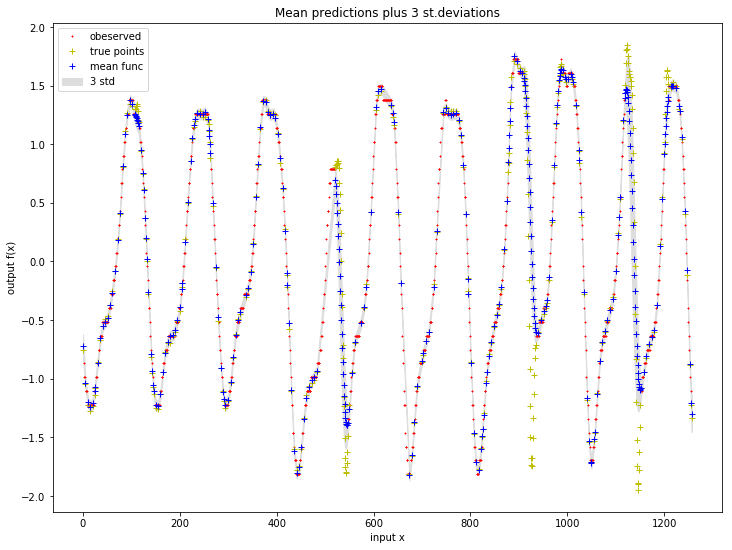

-LML = -1374.1657708


In [116]:
hyps = hyp_opt.x.reshape(6,1)
print "optimised hyperparameters = ", hyps
LML = f_to_optimise(hyps, kernel, X, Xtest, y, ytrue, True)
print "-LML = %s" %( LML)

In [405]:
# Fit a linear model: 

#compute the X matrix:
X_ = np.array([np.array([1, x]) for x in X ]).reshape( (len(X),2))
print "add a 1 to the data for the intercept term:", X_.shape
# X is nxd, theta = dx1, y is nx1

# Then compute normal equations to compute MLE for theta
b = np.matmul(X_.T, X_) 
c = np.matmul(np.linalg.inv(b), X_.T)
(theta1, theta2) = np.matmul(c, y)

#theta MLE: 
theta1, theta2

add a 1 to the data for the intercept term: (917, 2)


(-0.17044037898913769, 0.00028099989488254191)